In [10]:
import torch
from xopt import Xopt
import yaml

YAML = """
xopt:
    dump_file: dump.yaml
generator:
    name: bayesian_exploration
    n_initial: 5
    optim:
        num_restarts: 1
    acq:
        proximal_lengthscales: [1.5, 1.5]

evaluator:
    name: test_TNK
    function: xopt.resources.test_functions.tnk.evaluate_TNK

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""
yaml_output = yaml.safe_load(YAML)

In [11]:
X = Xopt(config=yaml_output)

In [12]:
X.step()

for i in range(5):
    print(f"step {i}")
    X.step()

step 0
step 1
step 2
step 3
step 4


In [13]:
X.data

,x1,x2,a,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str
1,2.794563,1.227229,dummy_constant,2.794563,1.227229,8.221313,5.793880,"[1, 2, 3]",False,
2,2.488505,1.427704,dummy_constant,2.488505,1.427704,7.277169,4.814785,"[1, 2, 3]",False,
3,1.772335,0.332406,dummy_constant,1.772335,0.332406,2.350135,1.646925,"[1, 2, 3]",False,
4,0.210758,3.039773,dummy_constant,0.210758,3.039773,8.239955,6.534108,"[1, 2, 3]",False,
5,1.224799,1.402258,dummy_constant,1.224799,1.402258,2.419253,1.339403,"[1, 2, 3]",False,
6,1.311749,1.181340,dummy_constant,1.311749,1.181340,2.049219,1.123161,"[1, 2, 3]",False,
7,1.483886,1.271070,dummy_constant,1.483886,1.271070,2.784444,1.562580,"[1, 2, 3]",False,
8,1.404123,0.801104,dummy_constant,1.404123,0.801104,1.656068,0.908102,"[1, 2, 3]",False,
9,1.173383,0.741445,dummy_constant,1.173383,0.741445,1.018351,0.511740,"[1, 2, 3]",False,
10,1.119514,0.708830,dummy_constant,1.119514,0.708830,0.848103,0.427408,"[1, 2, 3]",False,


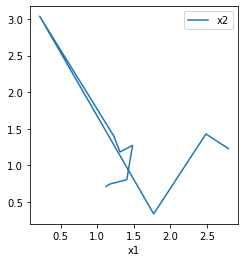

In [14]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

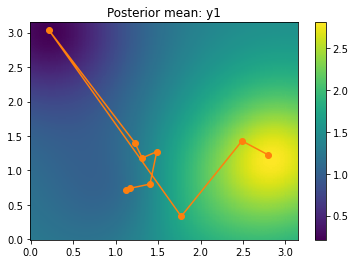

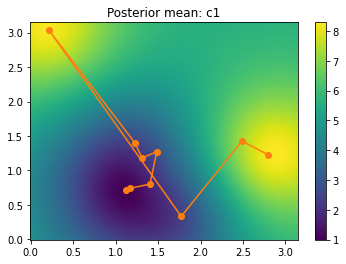

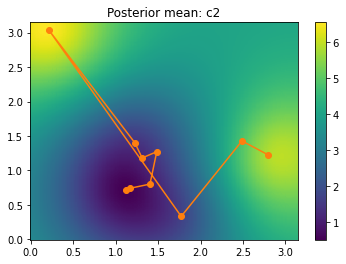

In [15]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 200
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = X.generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    for i in range(mean.shape[-1]):
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "o-C1")
        c = ax.pcolor(xx, yy, mean[:, i].reshape(n, n))
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

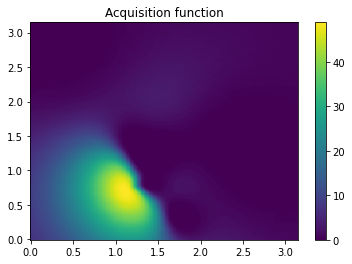

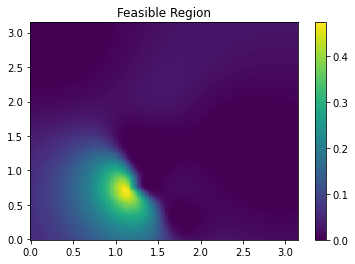

In [16]:
from xopt.generators.bayesian.utils import feasibility

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n))
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    feas = feasibility(pts.unsqueeze(1), model, X.generator.sampler, X.vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")